In [2]:
import functions as fn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import xgboost as xgb
import requests
from fake_useragent import UserAgent
from io import BytesIO
import warnings

warnings.filterwarnings("ignore")

In [10]:
# response = requests.get(f'https://www.fao.org/docs/worldfoodsituationlibraries/default-document-library/food_price_indices_data_a24.xls',
#                         headers={'User-Agent': str(UserAgent().random).strip()})
#
# dff = pd.read_excel(BytesIO(response.content))
#
# dff.drop(dff.columns[2:], axis=1, inplace=True)
# dff.drop([0, 1, 2], axis=0, inplace=True)
# dff = dff.dropna().iloc[:-3].reset_index(drop=True)
#
# dff.columns = ['Дата', 'ФАО']
#
# dff['Дата'] = pd.to_datetime(dff['Дата'], format='%Y-%m-%d %H:%M:%S')
# dff = dff.astype({'ФАО': float})
# dff = dff.sort_values(by=['Дата'])

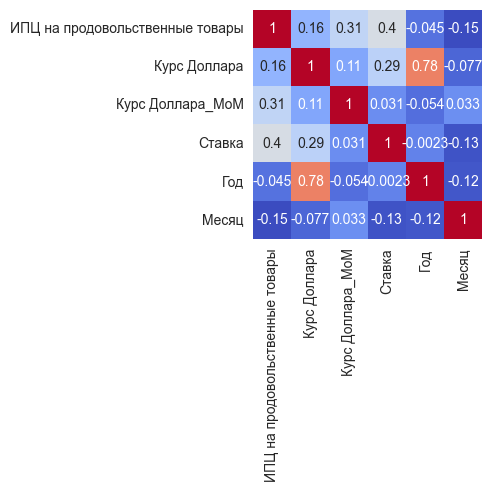

In [4]:
df = fn.get_CPI_data_from_rosstat(type_CPI='01').merge(
    fn.get_CPI_data_from_rosstat(type_CPI='02')[['Дата', fn.CPI_guide['02'][0]]],
    on='Дата',
    how='left').merge(fn.get_CPI_data_from_rosstat(type_CPI='03')[['Дата', fn.CPI_guide['03'][0]]],
                      on='Дата',
                      how='left').merge(fn.get_CPI_data_from_rosstat(type_CPI='04')[['Дата', fn.CPI_guide['04'][0]]],
                                        on='Дата',
                                        how='left')
df['Дата'] = pd.to_datetime(df['Дата'])

df2 = fn.get_DollarER_data_from_cbr()

df3 = fn.get_KR_data_from_cbr()

df_glob = df.merge(df2, on='Дата', how='left').merge(df3, on='Дата', how='left')  #.merge(dff, on='Дата', how='left')

df_glob = df_glob.dropna()
df_glob['Год'] = pd.DatetimeIndex(df_glob['Дата']).year
df_glob['Месяц'] = pd.DatetimeIndex(df_glob['Дата']).month

df_fc = df_glob.copy()[['Дата', 'ИПЦ на продовольственные товары', 'Курс Доллара', 'Курс Доллара_MoM', 'Ставка', 'Год', 'Месяц']]
df_fc = df_fc.set_index('Дата')

corr = df_fc.corr()['ИПЦ на продовольственные товары']
pd.DataFrame(corr)
corr = df_fc.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=False)
plt.tight_layout(pad=1.0)

In [5]:
df_val = df_glob[-6:]
df_tt = df_glob[:-6]

X_val, y_val = df_val[-6:].loc[:, ['Курс Доллара_MoM', 'Ставка']].values, df_val[-6:].loc[:, ['ИПЦ на продовольственные товары']].values

X, y = df_tt.loc[:, ['Курс Доллара_MoM', 'Ставка']].values, df_tt.loc[:, ['ИПЦ на продовольственные товары']].values

X_train = X[:int(len(X) * 0.8)]
y_train = y[:int(len(X) * 0.8)]

X_test = X[int(len(X) * 0.8):]
y_test = y[int(len(X) * 0.8):]

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_predictions = lr.predict(X_test)

print("MSE: %f" % (mean_squared_error(y_test, lr_predictions)))
print("MAPE: %f" % (np.mean(np.abs((y_test - lr_predictions) / y_test)) * 100))

MSE: 1.637081
MAPE: 0.949548


In [7]:
import pickle

# model - ваша обученная модель
with open('02.pkl', 'wb') as f:
    pickle.dump(lr, f)


In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

rf_predictions = rf.predict(X_test)

print("MSE: %f" % (mean_squared_error(y_test, rf_predictions)))
print("MAPE: %f" % (np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100))

MSE: 1.032405
MAPE: 1.221644


In [37]:
XGB = xgb.XGBRegressor(objective='reg:squarederror')
XGB.fit(X_train, y_train)

XGB_predictions = XGB.predict(X_test)

print("MSE: %f" % (mean_squared_error(y_test, XGB_predictions)))
print("MAPE: %f" % (np.mean(np.abs((y_test - XGB_predictions) / y_test)) * 100))

MSE: 0.876824
MAPE: 1.337099


In [38]:
from sklearn.model_selection import GridSearchCV

# Определим модель
model = xgb.XGBRegressor()

# Определим сетку параметров, которые мы хотим проверить
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Создадим объект GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучим GridSearchCV на обучающей выборке
grid_search.fit(X_train, y_train)

# Выведем лучшие параметры и соответствующий результат
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


In [39]:
XGB_p = xgb.XGBRegressor(objective='reg:squarederror',
                         colsample_bytree=0.8,
                         gamma=0.2,
                         learning_rate=0.01,
                         max_depth=3,
                         min_child_weight=1,
                         n_estimators=100,
                         subsample=1.0)

XGB_p.fit(X_train, y_train)

XGB_p_predictions = XGB_p.predict(X_test)

print("MSE: %f" % (mean_squared_error(y_test, XGB_p_predictions)))
print("MAPE: %f" % (np.mean(np.abs((y_test - XGB_p_predictions) / y_test)) * 100))

MSE: 1.525496
MAPE: 1.067446


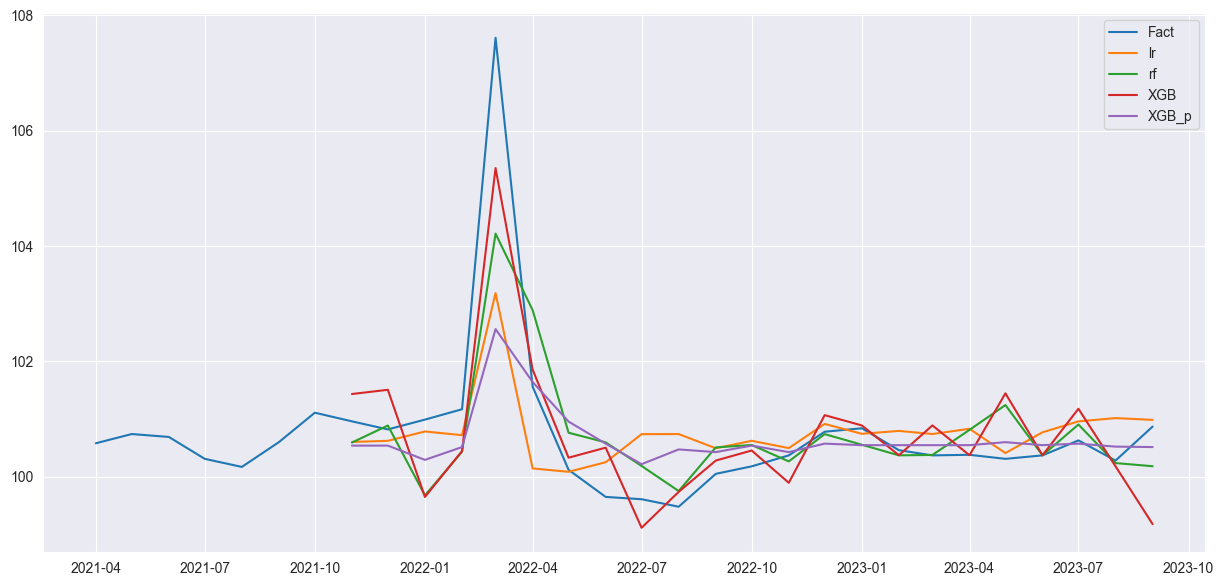

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(df_tt['Дата'][-30:], df_tt['ИПЦ на товары и услуги'][-30:], label="Fact")
plt.plot(df_tt['Дата'][-len(lr_predictions):], lr_predictions, label="lr")
plt.plot(df_tt['Дата'][-len(rf_predictions):], rf_predictions, label="rf")
plt.plot(df_tt['Дата'][-len(XGB_predictions):], XGB_predictions, label="XGB")
plt.plot(df_tt['Дата'][-len(XGB_p_predictions):], XGB_p_predictions, label="XGB_p")
plt.legend(loc="best")
plt.grid(True)

In [41]:
lr_predictions_val = lr.predict(X_val)
rf_predictions_val = rf.predict(X_val)
XGB_predictions_val = XGB.predict(X_val)
XGB_p_predictions_val = XGB_p.predict(X_val)

In [42]:
print('lr_predictions_val')
print("MSE: %f" % (mean_squared_error(y_val, lr_predictions_val)))
print("MAPE: %f" % (np.mean(np.abs((y_val - lr_predictions_val) / y_val)) * 100))

print('rf_predictions_val')
print("MSE: %f" % (mean_squared_error(y_val, rf_predictions_val)))
print("MAPE: %f" % (np.mean(np.abs((y_val - rf_predictions_val) / y_val)) * 100))

print('XGB_predictions_val')
print("MSE: %f" % (mean_squared_error(y_val, XGB_predictions_val)))
print("MAPE: %f" % (np.mean(np.abs((y_val - XGB_predictions_val) / y_val)) * 100))

print('XGB_p_predictions_val')
print("MSE: %f" % (mean_squared_error(y_val, XGB_p_predictions_val)))
print("MAPE: %f" % (np.mean(np.abs((y_val - XGB_p_predictions_val) / y_val)) * 100))

lr_predictions_val
MSE: 0.377844
MAPE: 0.533548
rf_predictions_val
MSE: 1.830427
MAPE: 1.173481
XGB_predictions_val
MSE: 7.627339
MAPE: 2.394228
XGB_p_predictions_val
MSE: 0.568210
MAPE: 0.526021


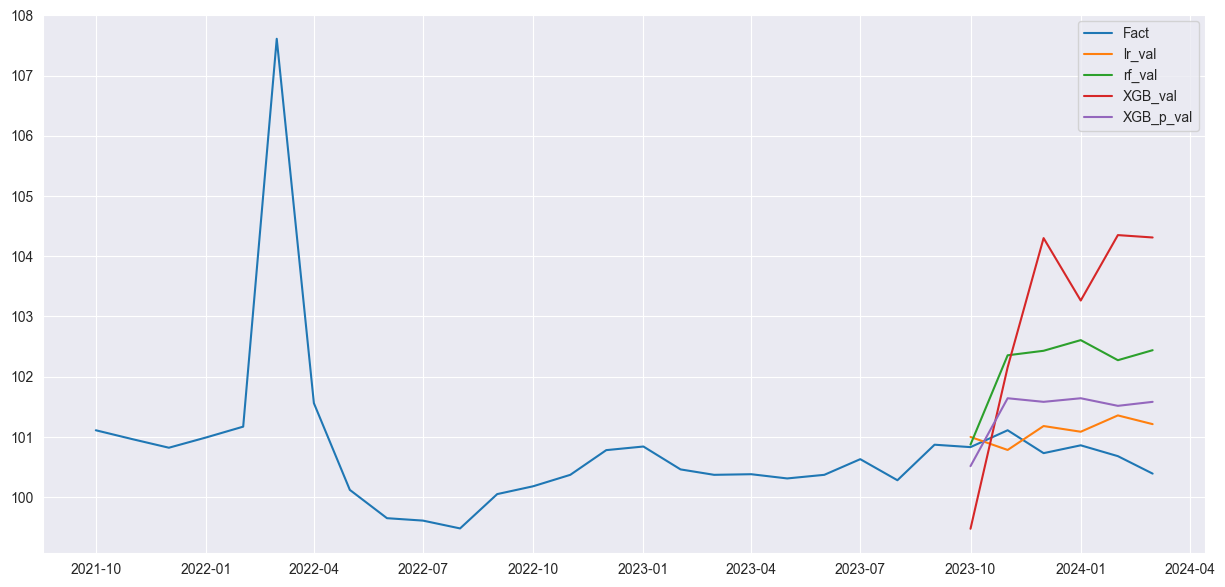

In [43]:
plt.figure(figsize=(15, 7))
plt.plot(df_glob['Дата'][-30:], df_glob['ИПЦ на товары и услуги'][-30:], label="Fact")

# plt.plot(df_tt['Дата'][-len(lr_predictions):], lr_predictions, label="lr")
# plt.plot(df_tt['Дата'][-len(rf_predictions):], rf_predictions, label="rf")
# plt.plot(df_tt['Дата'][-len(XGB_predictions):], XGB_predictions, label="XGB")
# plt.plot(df_tt['Дата'][-len(XGB_p_predictions):], XGB_p_predictions, label="XGB_p")

plt.plot(df_val['Дата'], lr_predictions_val, label="lr_val")
plt.plot(df_val['Дата'], rf_predictions_val, label="rf_val")
plt.plot(df_val['Дата'], XGB_predictions_val, label="XGB_val")
plt.plot(df_val['Дата'], XGB_p_predictions_val, label="XGB_p_val")
plt.legend(loc="best")
plt.grid(True)

In [103]:
# std_error = np.sqrt(mse)
#
# lower_bound = predictions_val - 1.96 * std_error
# upper_bound = predictions_val + 1.96 * std_error
#
# fig = make_subplots(rows=1, cols=1)
#
# # Исходные данные
# fig.add_trace(go.Scatter(x=df['Дата'][-30:], y=df['ИПЦ на товары и услуги'][-30:], mode='lines', name='ИПЦ на товары и услуги', marker=dict(color='#0088BB')))
# fig.add_trace(go.Scatter(x=df_val['Дата'], y=pd.Series(predictions_val.flatten()), mode='lines', name="Прогноз ИПЦ на товары и услуги", marker=dict(color='#EE1133')))
#
# fig.add_trace(go.Scatter(x=df_val['Дата'], y=lower_bound.ravel(), fill=None, mode='lines', name='Верхний доверительный интервал 95%', marker=dict(color='#00b050')))
# fig.add_trace(go.Scatter(x=df_val['Дата'], y=upper_bound.ravel(), fill='tonexty', mode='lines', name='Нижний доверительный интервал 95%', marker=dict(color='#00b050'), fillcolor='rgba(146, 208, 80, 0.2)'))
#
# fig.update_layout(legend_orientation="h", legend=dict(x=.5, xanchor="center"), margin=dict(l=30, r=30, t=20, b=30))
# fig.update_traces(hoverinfo="all", hovertemplate="Месяц: %{x}<br>Значение: %{y}")
#
# fig.show()

In [ ]:
import pickle

# model - ваша обученная модель
with open('02.pkl', 'wb') as f:
    pickle.dump(lr, f)
